<a href="https://colab.research.google.com/github/TeAmP0is0N/Fake-News-Hindi/blob/master/models/Davidson/Implementing_Davidson's_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import nltk
import os
import pickle
import joblib
import numpy as np
import pandas as pd
import math
import copy
import re
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment import util 
from nltk.corpus import treebank
from collections import Counter

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('indian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package indian to /root/nltk_data...
[nltk_data]   Package indian is already up-to-date!


True

In [ ]:
pd.options.display.max_colwidth = 0

In [ ]:
train = pd.read_csv("/gdrive/My Drive/3rd Sem/MTech CSE 3/Thesis/IIITD Fake News Project/Data Set/Constraint 21/Hostility Approach/Complete Dataset/Final Processed Dataset/70-10-20/train.csv")
test = pd.read_csv("/gdrive/My Drive/3rd Sem/MTech CSE 3/Thesis/IIITD Fake News Project/Data Set/Constraint 21/Hostility Approach/Complete Dataset/Final Processed Dataset/70-10-20/valid.csv")
# test  = pd.read_csv("/gdrive/My Drive/3rd Sem/MTech CSE 3/Thesis/IIITD Fake News Project/Data Set/Constraint 21/Hostility Approach/Complete Dataset/Final Processed Dataset/70-10-20/test.csv")

In [ ]:
print(train.shape)
# print(valid.shape)
print(test.shape)

(5728, 3)
(811, 3)


In [ ]:
train.head(5)

,Unique ID,Post,Labels Set
0,1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है \n\n🙏 जय श्री राम 🙏,"hate,offensive"
1,2,"सरकार हमेशा से किसानों की कमाई को बढ़ाने के लिए नई-नई स्कीमें लाती रहती है, ताकि उन पर ज्यादा आर्थिक बोझ न पड़े.\n\nhttps://t.co/8iy2MJSBAs",non-hostile
2,3,"सुशांत ने जो बिजनेस डील 9 जून को की थी, वो डील दीपेश को सुशांत की हत्या के दिन ही क्यों याद आई? देखिए 'पूछता है भारत' अर्नब के साथ रिपब्लिक भारत पर #LIVE : https://t.co/G945HvzM0Z https://t.co/KfH7xF1IdM",non-hostile
3,4,@prabhav218 साले जेएनयू छाप कमिने लोग हिन्दुओं को यह कहते है की संविधान सबको बराबर अधिकार देता है। सच्चाई यह है कि यह बराबर अधिकार नहीं देता है।,"defamation,offensive"
4,5,#unlock4guidelines - अनलॉक-4 के लिए गाइडलाइन्स जारी\n\n- 7 सितंबर से देशभर में मेट्रो सेवा शुरु होगी\n- 21 सितंबर के बाद रैलियों और बाकी फंक्शन में 100 लोगों को इजाजत\n- कंटेनमेंट जोन में कोई छूट नहीं\n- सिनेमाहॉल अभी बंद रहेंगे\n- 9 से 12वीं के छात्र 21 सितंबर के बाद स्कूल जा सकेंगे. https://t.co/4e6lysg0VR,non-hostile


In [ ]:
# train = train.iloc[:50,[1,2]]
# test = test.iloc[:50,[1,2]]

train.head(5)


,Unique ID,Post,Labels Set
0,1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है \n\n🙏 जय श्री राम 🙏,"hate,offensive"
1,2,"सरकार हमेशा से किसानों की कमाई को बढ़ाने के लिए नई-नई स्कीमें लाती रहती है, ताकि उन पर ज्यादा आर्थिक बोझ न पड़े.\n\nhttps://t.co/8iy2MJSBAs",non-hostile
2,3,"सुशांत ने जो बिजनेस डील 9 जून को की थी, वो डील दीपेश को सुशांत की हत्या के दिन ही क्यों याद आई? देखिए 'पूछता है भारत' अर्नब के साथ रिपब्लिक भारत पर #LIVE : https://t.co/G945HvzM0Z https://t.co/KfH7xF1IdM",non-hostile
3,4,@prabhav218 साले जेएनयू छाप कमिने लोग हिन्दुओं को यह कहते है की संविधान सबको बराबर अधिकार देता है। सच्चाई यह है कि यह बराबर अधिकार नहीं देता है।,"defamation,offensive"
4,5,#unlock4guidelines - अनलॉक-4 के लिए गाइडलाइन्स जारी\n\n- 7 सितंबर से देशभर में मेट्रो सेवा शुरु होगी\n- 21 सितंबर के बाद रैलियों और बाकी फंक्शन में 100 लोगों को इजाजत\n- कंटेनमेंट जोन में कोई छूट नहीं\n- सिनेमाहॉल अभी बंद रहेंगे\n- 9 से 12वीं के छात्र 21 सितंबर के बाद स्कूल जा सकेंगे. https://t.co/4e6lysg0VR,non-hostile


##Pre-Processing

In [ ]:
def preprocessing(df):
    df.insert(1,'Processed Tweet Text', np.zeros(len(df),dtype=str))
    ps = PorterStemmer()

    for i in range(len(df)):
        text = df['Post'][i]
        text = text.lower()
        text = text.split('\n')
        text = ''.join([sent for sent in text if len(sent)!=0])

        text = word_tokenize(text)
        for word in text:
            word = ps.stem(word)
        text = ' '.join(text)

        text = re.sub('http[a-zA-Z0-9./:]*', ' https://someurl',text)
        text = re.sub('@[a-zA-Z0-9_]*', '@someuser', text)
        # text = re.sub(r'[^\w\s]','',text)


        df.at[i,'Processed Tweet Text'] = text

    return df 

In [ ]:
def add_labels(df):

    df.insert(len(df.columns)-1,'Hostile', np.zeros(len(df),dtype=int))
    df.insert(len(df.columns)-1,'Defamation', np.zeros(len(df),dtype=int))
    df.insert(len(df.columns)-1,'Fake', np.zeros(len(df),dtype=int))
    df.insert(len(df.columns)-1,'Hate', np.zeros(len(df),dtype=int))
    df.insert(len(df.columns)-1,'Offensive', np.zeros(len(df),dtype=int))
    df.insert(len(df.columns)-1,'Non-Hostile', np.zeros(len(df),dtype=int))

    for i in range(len(df)):
        count = 0
        text = df['Labels Set'][i]
        text   = text.split(',')

        for word in text:
            if word == 'defamation':
                df.at[i,'Hostile']    = 1
                df.at[i,'Defamation'] = 1

            if word == 'fake':
                df.at[i,'Hostile']    = 1
                df.at[i,'Fake'] = 1

            if word == 'hate':
                df.at[i,'Hostile']    = 1
                df.at[i,'Hate'] = 1

            if word == 'offensive':
                df.at[i,'Hostile']    = 1
                df.at[i,'Offensive'] = 1

            if word == 'non-hostile' and df['Hostile'][i]==0:
                df.at[i,'Hostile']    = 0
                df.at[i,'Non-Hostile'] = 1                                                                

    df = df.drop(columns=['Labels Set'],axis=1)
    return df

##Implementing Features

In [ ]:
def add_ngrams(df,choice,tfidf):

    if(choice == 1):
        tfidf = TfidfVectorizer(ngram_range=(1,3), min_df=3, max_df=0.92)
        ngrams = tfidf.fit_transform(df['Processed Tweet Text'])

    else:
        ngrams = tfidf.transform(df['Processed Tweet Text'].to_list())

    ngrams_df = pd.DataFrame(ngrams.toarray(), columns = tfidf.get_feature_names())
    df = pd.concat([df['Post'],df['Processed Tweet Text'],ngrams_df,df.iloc[:,-6:]], axis=1)
    return df,tfidf

In [ ]:
from nltk.tag import tnt
from nltk.corpus import indian

def add_pos_ngrams(df,choice,cv):

    train_data = indian.tagged_sents('hindi.pos')
    tnt_pos_tagger = tnt.TnT()
    tnt_pos_tagger.train(train_data)

    pos_corpus = []
    for i in range(len(df)):
        sample = []
        text = df['Processed Tweet Text'][i]
        tagged_words = (tnt_pos_tagger.tag(nltk.word_tokenize(text)))
        for pair in tagged_words:
            sample.append(pair[1])
        sample = ' '.join(sample)
        pos_corpus.append(sample)


    if(choice == 1):
        cv = CountVectorizer(ngram_range=(1,3), min_df=2, max_df=.92)
        ngrams = cv.fit_transform(pos_corpus)
    else:
        ngrams = cv.transform(pos_corpus)

    ngrams_df = pd.DataFrame(ngrams.toarray(), columns = cv.get_feature_names())
    df = pd.concat([df.iloc[:,:-6],ngrams_df,df.iloc[:,-6:]], axis=1)

    return df,cv

In [ ]:
def add_num_hashtags(df):
    df.insert(len(df.columns)-6,'Number of Hashtags', np.zeros(len(df)))
    df.insert(len(df.columns)-6,'Hashtags Exist', np.zeros(len(df)))

    for i in range(len(df)):
        count = 0
        text = df['Post'][i]
        for word in text:
            for char in word:
                if(char == '#'):
                    count += 1

        df.at[i,'Number of Hashtags'] = count
        if count>0:
            df.at[i,'Hashtags Exist'] = 1

    return df

In [ ]:
def add_num_urls(df):
    df.insert(len(df.columns)-6,'Number of URLs', np.zeros(len(df)))
    df.insert(len(df.columns)-6,'URLs Exist', np.zeros(len(df)))

    for i in range(len(df)):
        count = 0
        text  = df['Post'][i]
        text  = re.findall('http[a-zA-Z0-9./:]*',text)
        count = len(text) 

        df.at[i,'Number of URLs'] = count
        if count>0:
            df.at[i,'URLs Exist'] = 1
            
    return df

In [ ]:
def add_num_mentions(df):
    df.insert(len(df.columns)-6,'Number of Mentions', np.zeros(len(df)))
    df.insert(len(df.columns)-6,'Mentions Exist', np.zeros(len(df)))

    for i in range(len(df)):
        count = 0
        text = df['Post'][i]
        for word in text:
            for char in word:
                if(char == '@'):
                    count += 1

        df.at[i,'Number of Mentions'] = count
        if count>0:
            df.at[i,'Mentions Exist'] = 1
            
    return df

In [ ]:
def add_num_chars(df):
    df.insert(len(df.columns)-6,'Number of Characters', np.zeros(len(df)))
    df.insert(len(df.columns)-6,'Number of Words', np.zeros(len(df)))

    for i in range(len(df)):
        count = 0
        text = df['Post'][i]
        for word in text:
            for char in word:
                count += 1

        words_count = len(text.split())

        df.at[i,'Number of Characters'] = count
        df.at[i,'Number of Words'] = words_count
            
    return df

In [ ]:
### Reference: https://stackoverflow.com/questions/47000655/syllabification-of-devanagari

import unicodedata

def split_clusters(txt):
    """ Generate grapheme clusters for the Devanagari text."""

    stop = '्'
    cluster = u''
    end = None

    for char in txt:
        category = unicodedata.category(char)
        if (category == 'Lo' and end == stop) or category == 'Mn':
            cluster = cluster + char        
        else:
            if cluster:
                yield cluster
            cluster = char
        end = char

    if cluster:
        yield cluster

In [ ]:
def add_num_syllables(df):
    df.insert(len(df.columns)-6,'Number of Syllables', np.zeros(len(df)))

    for i in range(len(df)):
        count = 0
        text = df['Post'][i]
        text = text.split()
        for word in text:
            count += len(list(split_clusters(word)))

        df.at[i,'Number of Syllables'] = count            
    return df


##Checking Features

In [ ]:
train = preprocessing(train)
test  = preprocessing(test)

print("Train Shape: ",train.shape)
print("Test Shape: ",test.shape)


train.head(5)

Train Shape:  (5728, 4)
Test Shape:  (811, 4)


,Unique ID,Processed Tweet Text,Post,Labels Set
0,1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है 🙏 जय श्री राम 🙏,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है \n\n🙏 जय श्री राम 🙏,"hate,offensive"
1,2,"सरकार हमेशा से किसानों की कमाई को बढ़ाने के लिए नई-नई स्कीमें लाती रहती है , ताकि उन पर ज्यादा आर्थिक बोझ न पड़े. https://someurl : //t.co/8iy2mjsbas","सरकार हमेशा से किसानों की कमाई को बढ़ाने के लिए नई-नई स्कीमें लाती रहती है, ताकि उन पर ज्यादा आर्थिक बोझ न पड़े.\n\nhttps://t.co/8iy2MJSBAs",non-hostile
2,3,"सुशांत ने जो बिजनेस डील 9 जून को की थी , वो डील दीपेश को सुशांत की हत्या के दिन ही क्यों याद आई ? देखिए 'पूछता है भारत ' अर्नब के साथ रिपब्लिक भारत पर # live : https://someurl : //t.co/g945hvzm0z https://someurl : //t.co/kfh7xf1idm","सुशांत ने जो बिजनेस डील 9 जून को की थी, वो डील दीपेश को सुशांत की हत्या के दिन ही क्यों याद आई? देखिए 'पूछता है भारत' अर्नब के साथ रिपब्लिक भारत पर #LIVE : https://t.co/G945HvzM0Z https://t.co/KfH7xF1IdM",non-hostile
3,4,@someuser prabhav218 साले जेएनयू छाप कमिने लोग हिन्दुओं को यह कहते है की संविधान सबको बराबर अधिकार देता है। सच्चाई यह है कि यह बराबर अधिकार नहीं देता है।,@prabhav218 साले जेएनयू छाप कमिने लोग हिन्दुओं को यह कहते है की संविधान सबको बराबर अधिकार देता है। सच्चाई यह है कि यह बराबर अधिकार नहीं देता है।,"defamation,offensive"
4,5,# unlock4guidelines - अनलॉक-4 के लिए गाइडलाइन्स जारी- 7 सितंबर से देशभर में मेट्रो सेवा शुरु होगी- 21 सितंबर के बाद रैलियों और बाकी फंक्शन में 100 लोगों को इजाजत- कंटेनमेंट जोन में कोई छूट नहीं- सिनेमाहॉल अभी बंद रहेंगे- 9 से 12वीं के छात्र 21 सितंबर के बाद स्कूल जा सकेंगे . https://someurl : //t.co/4e6lysg0vr,#unlock4guidelines - अनलॉक-4 के लिए गाइडलाइन्स जारी\n\n- 7 सितंबर से देशभर में मेट्रो सेवा शुरु होगी\n- 21 सितंबर के बाद रैलियों और बाकी फंक्शन में 100 लोगों को इजाजत\n- कंटेनमेंट जोन में कोई छूट नहीं\n- सिनेमाहॉल अभी बंद रहेंगे\n- 9 से 12वीं के छात्र 21 सितंबर के बाद स्कूल जा सकेंगे. https://t.co/4e6lysg0VR,non-hostile


In [ ]:
train = add_labels(train)
test  = add_labels(test)

print("Train Shape: ",train.shape)
print("Test Shape: ",test.shape)


train.head(5)

Train Shape:  (5728, 9)
Test Shape:  (811, 9)


,Unique ID,Processed Tweet Text,Post,Hostile,Defamation,Fake,Hate,Offensive,Non-Hostile
0,1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है 🙏 जय श्री राम 🙏,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है \n\n🙏 जय श्री राम 🙏,1,0,0,1,1,0
1,2,"सरकार हमेशा से किसानों की कमाई को बढ़ाने के लिए नई-नई स्कीमें लाती रहती है , ताकि उन पर ज्यादा आर्थिक बोझ न पड़े. https://someurl : //t.co/8iy2mjsbas","सरकार हमेशा से किसानों की कमाई को बढ़ाने के लिए नई-नई स्कीमें लाती रहती है, ताकि उन पर ज्यादा आर्थिक बोझ न पड़े.\n\nhttps://t.co/8iy2MJSBAs",0,0,0,0,0,1
2,3,"सुशांत ने जो बिजनेस डील 9 जून को की थी , वो डील दीपेश को सुशांत की हत्या के दिन ही क्यों याद आई ? देखिए 'पूछता है भारत ' अर्नब के साथ रिपब्लिक भारत पर # live : https://someurl : //t.co/g945hvzm0z https://someurl : //t.co/kfh7xf1idm","सुशांत ने जो बिजनेस डील 9 जून को की थी, वो डील दीपेश को सुशांत की हत्या के दिन ही क्यों याद आई? देखिए 'पूछता है भारत' अर्नब के साथ रिपब्लिक भारत पर #LIVE : https://t.co/G945HvzM0Z https://t.co/KfH7xF1IdM",0,0,0,0,0,1
3,4,@someuser prabhav218 साले जेएनयू छाप कमिने लोग हिन्दुओं को यह कहते है की संविधान सबको बराबर अधिकार देता है। सच्चाई यह है कि यह बराबर अधिकार नहीं देता है।,@prabhav218 साले जेएनयू छाप कमिने लोग हिन्दुओं को यह कहते है की संविधान सबको बराबर अधिकार देता है। सच्चाई यह है कि यह बराबर अधिकार नहीं देता है।,1,1,0,0,1,0
4,5,# unlock4guidelines - अनलॉक-4 के लिए गाइडलाइन्स जारी- 7 सितंबर से देशभर में मेट्रो सेवा शुरु होगी- 21 सितंबर के बाद रैलियों और बाकी फंक्शन में 100 लोगों को इजाजत- कंटेनमेंट जोन में कोई छूट नहीं- सिनेमाहॉल अभी बंद रहेंगे- 9 से 12वीं के छात्र 21 सितंबर के बाद स्कूल जा सकेंगे . https://someurl : //t.co/4e6lysg0vr,#unlock4guidelines - अनलॉक-4 के लिए गाइडलाइन्स जारी\n\n- 7 सितंबर से देशभर में मेट्रो सेवा शुरु होगी\n- 21 सितंबर के बाद रैलियों और बाकी फंक्शन में 100 लोगों को इजाजत\n- कंटेनमेंट जोन में कोई छूट नहीं\n- सिनेमाहॉल अभी बंद रहेंगे\n- 9 से 12वीं के छात्र 21 सितंबर के बाद स्कूल जा सकेंगे. https://t.co/4e6lysg0VR,0,0,0,0,0,1


In [ ]:
# df = copy.deepcopy(train)

tfidf = 0
train,tfidf = add_ngrams(train,1,tfidf)
test,tfidf  = add_ngrams(test,0,tfidf)

print("Train Shape: ",train.shape)
print("Test Shape: ",test.shape)


train.head(5)

Train Shape:  (5728, 8947)
Test Shape:  (811, 8947)


,Post,Processed Tweet Text,00,00 बज,000,000 अध,000 कर,000 पय,01,02,04,05,06,07,08,081,10,10 कर,10 बज,10 बड,10 बड https,10 बर,10 रत,10 रत शत,10 वर,10 सद,10 हज,10 हफ,10 हफ चलन,100,100 कर,100 गल,100 गल टक,100 टर,100 धक,1000,1000 वर,103,108,10व,...,हर मज,हर मन,हर मह,हर रत,हर रम,हर रव,हर रह,हर वक,हर वर,हर षवर,हर षवर धन,हर समय,हर सरक,हर हर,हर हर मह,हरकत,हरकत पर,हरकत पर कह,हरण,हरत,हल,हव,हव अड,हव कर,हवस,हस,हस षर,हज़,हज़ कर,ख़त,ज़न,ज़र,ड़न,फ़र,Hostile,Defamation,Fake,Hate,Offensive,Non-Hostile
0,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है \n\n🙏 जय श्री राम 🙏,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है 🙏 जय श्री राम 🙏,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,1,0
1,"सरकार हमेशा से किसानों की कमाई को बढ़ाने के लिए नई-नई स्कीमें लाती रहती है, ताकि उन पर ज्यादा आर्थिक बोझ न पड़े.\n\nhttps://t.co/8iy2MJSBAs","सरकार हमेशा से किसानों की कमाई को बढ़ाने के लिए नई-नई स्कीमें लाती रहती है , ताकि उन पर ज्यादा आर्थिक बोझ न पड़े. https://someurl : //t.co/8iy2mjsbas",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1
2,"सुशांत ने जो बिजनेस डील 9 जून को की थी, वो डील दीपेश को सुशांत की हत्या के दिन ही क्यों याद आई? देखिए 'पूछता है भारत' अर्नब के साथ रिपब्लिक भारत पर #LIVE : https://t.co/G945HvzM0Z https://t.co/KfH7xF1IdM","सुशांत ने जो बिजनेस डील 9 जून को की थी , वो डील दीपेश को सुशांत की हत्या के दिन ही क्यों याद आई ? देखिए 'पूछता है भारत ' अर्नब के साथ रिपब्लिक भारत पर # live : https://someurl : //t.co/g945hvzm0z https://someurl : //t.co/kfh7xf1idm",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1
3,@prabhav218 साले जेएनयू छाप कमिने लोग हिन्दुओं को यह कहते है की संविधान सबको बराबर अधिकार देता है। सच्चाई यह है कि यह बराबर अधिकार नहीं देता है।,@someuser prabhav218 साले जेएनयू छाप कमिने लोग हिन्दुओं को यह कहते है की संविधान सबको बराबर अधिकार देता है। सच्चाई यह है कि यह बराबर अधिकार नहीं देता है।,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,0,1,0
4,#unlock4guidelines - अनलॉक-4 के लिए गाइडलाइन्स जारी\n\n- 7 सितंबर से देशभर में मेट्रो सेवा शुरु होगी\n- 21 सितंबर के बाद रैलियों और बाकी फंक्शन में 100 लोगों को इजाजत\n- कंटेनमेंट जोन में कोई छूट नहीं\n- सिनेमाहॉल अभी बंद रहेंगे\n- 9 से 12वीं के छात्र 21 सितंबर के बाद स्कूल जा सकेंगे. https://t.co/4e6lysg0VR,# unlock4guidelines - अनलॉक-4 के लिए गाइडलाइन्स जारी- 7 सितंबर से देशभर में मेट्रो सेवा शुरु होगी- 21 सितंबर के बाद रैलियों और बाकी फंक्शन में 100 लोगों को इजाजत- कंटेनमेंट जोन में कोई छूट नहीं- सिनेमाहॉल अभी बंद रहेंगे- 9 से 12वीं के छात्र 21 सितंबर के बाद स्कूल जा सकेंगे . https://someurl : //t.co/4e6lysg0vr,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.139249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1


In [ ]:
# df = copy.deepcopy(train)

cv=0
train,cv = add_pos_ngrams(train,1,cv)
test,cv  = add_pos_ngrams(test,0,cv)

print("Train Shape: ",train.shape)
print("Test Shape: ",test.shape)


train.head(5)

Train Shape:  (5728, 12817)
Test Shape:  (811, 12817)


,Post,Processed Tweet Text,00,00 बज,000,000 अध,000 कर,000 पय,01,02,04,05,06,07,08,081,10,10 कर,10 बज,10 बड,10 बड https,10 बर,10 रत,10 रत शत,10 वर,10 सद,10 हज,10 हफ,10 हफ चलन,100,100 कर,100 गल,100 गल टक,100 टर,100 धक,1000,1000 वर,103,108,10व,...,vrb qf,vrb qf nn,vrb qf unk,vrb qf vfm,vrb qfnum,vrb qfnum cc,vrb qfnum nn,vrb qfnum unk,vrb qw,vrb qw vfm,vrb rp,vrb rp unk,vrb unk,vrb unk cc,vrb unk jvb,vrb unk neg,vrb unk nn,vrb unk nnpc,vrb unk prep,vrb unk punc,vrb unk sym,vrb unk unk,vrb unk vaux,vrb unk vfm,vrb vaux,vrb vaux vfm,vrb vfm,vrb vfm cc,vrb vfm nn,vrb vfm prp,vrb vfm punc,vrb vfm unk,vrb vfm vaux,vrb vnn,Hostile,Defamation,Fake,Hate,Offensive,Non-Hostile
0,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है \n\n🙏 जय श्री राम 🙏,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है 🙏 जय श्री राम 🙏,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0
1,"सरकार हमेशा से किसानों की कमाई को बढ़ाने के लिए नई-नई स्कीमें लाती रहती है, ताकि उन पर ज्यादा आर्थिक बोझ न पड़े.\n\nhttps://t.co/8iy2MJSBAs","सरकार हमेशा से किसानों की कमाई को बढ़ाने के लिए नई-नई स्कीमें लाती रहती है , ताकि उन पर ज्यादा आर्थिक बोझ न पड़े. https://someurl : //t.co/8iy2mjsbas",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,"सुशांत ने जो बिजनेस डील 9 जून को की थी, वो डील दीपेश को सुशांत की हत्या के दिन ही क्यों याद आई? देखिए 'पूछता है भारत' अर्नब के साथ रिपब्लिक भारत पर #LIVE : https://t.co/G945HvzM0Z https://t.co/KfH7xF1IdM","सुशांत ने जो बिजनेस डील 9 जून को की थी , वो डील दीपेश को सुशांत की हत्या के दिन ही क्यों याद आई ? देखिए 'पूछता है भारत ' अर्नब के साथ रिपब्लिक भारत पर # live : https://someurl : //t.co/g945hvzm0z https://someurl : //t.co/kfh7xf1idm",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,@prabhav218 साले जेएनयू छाप कमिने लोग हिन्दुओं को यह कहते है की संविधान सबको बराबर अधिकार देता है। सच्चाई यह है कि यह बराबर अधिकार नहीं देता है।,@someuser prabhav218 साले जेएनयू छाप कमिने लोग हिन्दुओं को यह कहते है की संविधान सबको बराबर अधिकार देता है। सच्चाई यह है कि यह बराबर अधिकार नहीं देता है।,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
4,#unlock4guidelines - अनलॉक-4 के लिए गाइडलाइन्स जारी\n\n- 7 सितंबर से देशभर में मेट्रो सेवा शुरु होगी\n- 21 सितंबर के बाद रैलियों और बाकी फंक्शन में 100 लोगों को इजाजत\n- कंटेनमेंट जोन में कोई छूट नहीं\n- सिनेमाहॉल अभी बंद रहेंगे\n- 9 से 12वीं के छात्र 21 सितंबर के बाद स्कूल जा सकेंगे. https://t.co/4e6lysg0VR,# unlock4guidelines - अनलॉक-4 के लिए गाइडलाइन्स जारी- 7 सितंबर से देशभर में मेट्रो सेवा शुरु होगी- 21 सितंबर के बाद रैलियों और बाकी फंक्शन में 100 लोगों को इजाजत- कंटेनमेंट जोन में कोई छूट नहीं- सिनेमाहॉल अभी बंद रहेंगे- 9 से 12वीं के छात्र 21 सितंबर के बाद स्कूल जा सकेंगे . https://someurl : //t.co/4e6lysg0vr,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.139249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
temp = copy.deepcopy(train['Non-Hostile'])
train = train.iloc[:,:-10]
train = pd.concat([train,temp],axis=1)

In [ ]:
temp = copy.deepcopy(test['Non-Hostile'])
test = test.iloc[:,:-10]
test = pd.concat([test,temp],axis=1)

In [ ]:
test.head(5)

,Post,Processed Tweet Text,00,00 बज,000,000 अध,000 कर,000 पय,01,02,04,05,06,07,08,081,10,10 कर,10 बज,10 बड,10 बड https,10 बर,10 रत,10 रत शत,10 वर,10 सद,10 हज,10 हफ,10 हफ चलन,100,100 कर,100 गल,100 गल टक,100 टर,100 धक,1000,1000 वर,103,108,10व,...,vrb qf,vrb qf nn,vrb qf unk,vrb qf vfm,vrb qfnum,vrb qfnum cc,vrb qfnum nn,vrb qfnum unk,vrb qw,vrb qw vfm,vrb rp,vrb rp unk,vrb unk,vrb unk cc,vrb unk jvb,vrb unk neg,vrb unk nn,vrb unk nnpc,vrb unk prep,vrb unk punc,vrb unk sym,vrb unk unk,vrb unk vaux,vrb unk vfm,vrb vaux,vrb vaux vfm,vrb vfm,vrb vfm cc,vrb vfm nn,vrb vfm prp,vrb vfm punc,vrb vfm unk,vrb vfm vaux,vrb vnn,Hostile,Defamation,Fake,Hate,Offensive,Non-Hostile
0,दृढ़ इच्छा शक्ति से परिपूर्ण प्रणबदा के लिए देशहित सर्वोच्च रहा।\n\nउनका निधन हम सब के लिए अपूरणीय क्षति है।\nईश्वर दिवंगत आत्मा को अपने श्रीचरणों में स्थान दें। शोक संतप्त परिजनों के प्रति संवेदनाएं।\nऊं शांति!!!,दृढ़ इच्छा शक्ति से परिपूर्ण प्रणबदा के लिए देशहित सर्वोच्च रहा।उनका निधन हम सब के लिए अपूरणीय क्षति है।ईश्वर दिवंगत आत्मा को अपने श्रीचरणों में स्थान दें। शोक संतप्त परिजनों के प्रति संवेदनाएं।ऊं शांति ! ! !,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,भारतीय जनता पार्टी rss वाले इतने गिरे हुए हैं जहां मैं रहती हूं वहां मेरी जासूसी करा रहें है उसकी जासूस की पहचान मुझे अच्छी तरह है rss बीजेपी वाले की जासूस दिल्ली में कौन है उत्तर प्रदेश में कौन है हरियाणा राजस्थान में कौन है सबकी पहचान है मुझे मेरी नजर से बच नहीं सकते हो,भारतीय जनता पार्टी rss वाले इतने गिरे हुए हैं जहां मैं रहती हूं वहां मेरी जासूसी करा रहें है उसकी जासूस की पहचान मुझे अच्छी तरह है rss बीजेपी वाले की जासूस दिल्ली में कौन है उत्तर प्रदेश में कौन है हरियाणा राजस्थान में कौन है सबकी पहचान है मुझे मेरी नजर से बच नहीं सकते हो,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
2,"कोरोना से निपटने की तैयारी / दिल्ली में 10 हजार बेड वाला दुनिया का सबसे बड़ा कोविड केयर सेंटर शुरू, राजनाथ-शाह ने डीआरडीओ के 1 हजार बेड वाले सेंटर का भी उद्घाटन किया\nhttps://t.co/9rlQowAsFh #Delhi @ArvindKejriwal @rajnathsingh @AmitShah @DRDO_India @WHO @crpfindia @ITBP_official","कोरोना से निपटने की तैयारी / दिल्ली में 10 हजार बेड वाला दुनिया का सबसे बड़ा कोविड केयर सेंटर शुरू , राजनाथ-शाह ने डीआरडीओ के 1 हजार बेड वाले सेंटर का भी उद्घाटन किया https://someurl : //t.co/9rlqowasfh # delhi @someuser arvindkejriwal @someuser rajnathsingh @someuser amitshah @someuser drdo_india @someuser who @someuser crpfindia @someuser itbp_official",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.105374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.169545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,गवर्नर कॉन्फ्रेंस में PM मोदी बोले- शिक्षा नीति में सरकार का दखल कम होना चाहिए\nhttps://t.co/ZvKgxk6dbd,गवर्नर कॉन्फ्रेंस में pm मोदी बोले- शिक्षा नीति में सरकार का दखल कम होना चाहिए https://someurl : //t.co/zvkgxk6dbd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,"यूपी: गाजीपुर में Toilet घोटाला, प्रधान व सचिव ने किया लाखों का गबन, मुर्दों के नाम पर बनवा डाले शौचालय\n\n#UP\nhttps://t.co/hxM1uNNmX2","यूपी : गाजीपुर में toilet घोटाला , प्रधान व सचिव ने किया लाखों का गबन , मुर्दों के नाम पर बनवा डाले शौचालय # up https://someurl : //t.co/hxm1unnmx2",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [ ]:
# df = copy.deepcopy(train)

train = add_num_hashtags(train)
test = add_num_hashtags(test)

print("Train Shape: ",train.shape)
print("Test Shape: ",test.shape)

train.head(5)


Train Shape:  (5728, 12819)
Test Shape:  (811, 12819)


,Post,Processed Tweet Text,00,00 बज,000,000 अध,000 कर,000 पय,01,02,04,05,06,07,08,081,10,10 कर,10 बज,10 बड,10 बड https,10 बर,10 रत,10 रत शत,10 वर,10 सद,10 हज,10 हफ,10 हफ चलन,100,100 कर,100 गल,100 गल टक,100 टर,100 धक,1000,1000 वर,103,108,10व,...,vrb qf unk,vrb qf vfm,vrb qfnum,vrb qfnum cc,vrb qfnum nn,vrb qfnum unk,vrb qw,vrb qw vfm,vrb rp,vrb rp unk,vrb unk,vrb unk cc,vrb unk jvb,vrb unk neg,vrb unk nn,vrb unk nnpc,vrb unk prep,vrb unk punc,vrb unk sym,vrb unk unk,vrb unk vaux,vrb unk vfm,vrb vaux,vrb vaux vfm,vrb vfm,vrb vfm cc,vrb vfm nn,vrb vfm prp,vrb vfm punc,vrb vfm unk,vrb vfm vaux,vrb vnn,Number of Hashtags,Hashtags Exist,Hostile,Defamation,Fake,Hate,Offensive,Non-Hostile
0,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है \n\n🙏 जय श्री राम 🙏,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है 🙏 जय श्री राम 🙏,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0,0,1,1,0
1,"सरकार हमेशा से किसानों की कमाई को बढ़ाने के लिए नई-नई स्कीमें लाती रहती है, ताकि उन पर ज्यादा आर्थिक बोझ न पड़े.\n\nhttps://t.co/8iy2MJSBAs","सरकार हमेशा से किसानों की कमाई को बढ़ाने के लिए नई-नई स्कीमें लाती रहती है , ताकि उन पर ज्यादा आर्थिक बोझ न पड़े. https://someurl : //t.co/8iy2mjsbas",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,1
2,"सुशांत ने जो बिजनेस डील 9 जून को की थी, वो डील दीपेश को सुशांत की हत्या के दिन ही क्यों याद आई? देखिए 'पूछता है भारत' अर्नब के साथ रिपब्लिक भारत पर #LIVE : https://t.co/G945HvzM0Z https://t.co/KfH7xF1IdM","सुशांत ने जो बिजनेस डील 9 जून को की थी , वो डील दीपेश को सुशांत की हत्या के दिन ही क्यों याद आई ? देखिए 'पूछता है भारत ' अर्नब के साथ रिपब्लिक भारत पर # live : https://someurl : //t.co/g945hvzm0z https://someurl : //t.co/kfh7xf1idm",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0,0,0,0,0,1
3,@prabhav218 साले जेएनयू छाप कमिने लोग हिन्दुओं को यह कहते है की संविधान सबको बराबर अधिकार देता है। सच्चाई यह है कि यह बराबर अधिकार नहीं देता है।,@someuser prabhav218 साले जेएनयू छाप कमिने लोग हिन्दुओं को यह कहते है की संविधान सबको बराबर अधिकार देता है। सच्चाई यह है कि यह बराबर अधिकार नहीं देता है।,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,1,0,0,1,0
4,#unlock4guidelines - अनलॉक-4 के लिए गाइडलाइन्स जारी\n\n- 7 सितंबर से देशभर में मेट्रो सेवा शुरु होगी\n- 21 सितंबर के बाद रैलियों और बाकी फंक्शन में 100 लोगों को इजाजत\n- कंटेनमेंट जोन में कोई छूट नहीं\n- सिनेमाहॉल अभी बंद रहेंगे\n- 9 से 12वीं के छात्र 21 सितंबर के बाद स्कूल जा सकेंगे. https://t.co/4e6lysg0VR,# unlock4guidelines - अनलॉक-4 के लिए गाइडलाइन्स जारी- 7 सितंबर से देशभर में मेट्रो सेवा शुरु होगी- 21 सितंबर के बाद रैलियों और बाकी फंक्शन में 100 लोगों को इजाजत- कंटेनमेंट जोन में कोई छूट नहीं- सिनेमाहॉल अभी बंद रहेंगे- 9 से 12वीं के छात्र 21 सितंबर के बाद स्कूल जा सकेंगे . https://someurl : //t.co/4e6lysg0vr,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.139249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0,0,0,0,0,1


In [ ]:
# df = copy.deepcopy(train)

train = add_num_mentions(train)
test = add_num_mentions(test)

print("Train Shape: ",train.shape)
print("Test Shape: ",test.shape)

train.head(5)

Train Shape:  (5728, 12821)
Test Shape:  (811, 12821)


,Post,Processed Tweet Text,00,00 बज,000,000 अध,000 कर,000 पय,01,02,04,05,06,07,08,081,10,10 कर,10 बज,10 बड,10 बड https,10 बर,10 रत,10 रत शत,10 वर,10 सद,10 हज,10 हफ,10 हफ चलन,100,100 कर,100 गल,100 गल टक,100 टर,100 धक,1000,1000 वर,103,108,10व,...,vrb qfnum,vrb qfnum cc,vrb qfnum nn,vrb qfnum unk,vrb qw,vrb qw vfm,vrb rp,vrb rp unk,vrb unk,vrb unk cc,vrb unk jvb,vrb unk neg,vrb unk nn,vrb unk nnpc,vrb unk prep,vrb unk punc,vrb unk sym,vrb unk unk,vrb unk vaux,vrb unk vfm,vrb vaux,vrb vaux vfm,vrb vfm,vrb vfm cc,vrb vfm nn,vrb vfm prp,vrb vfm punc,vrb vfm unk,vrb vfm vaux,vrb vnn,Number of Hashtags,Hashtags Exist,Number of Mentions,Mentions Exist,Hostile,Defamation,Fake,Hate,Offensive,Non-Hostile
0,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है \n\n🙏 जय श्री राम 🙏,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है 🙏 जय श्री राम 🙏,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1,0,0,1,1,0
1,"सरकार हमेशा से किसानों की कमाई को बढ़ाने के लिए नई-नई स्कीमें लाती रहती है, ताकि उन पर ज्यादा आर्थिक बोझ न पड़े.\n\nhttps://t.co/8iy2MJSBAs","सरकार हमेशा से किसानों की कमाई को बढ़ाने के लिए नई-नई स्कीमें लाती रहती है , ताकि उन पर ज्यादा आर्थिक बोझ न पड़े. https://someurl : //t.co/8iy2mjsbas",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,1
2,"सुशांत ने जो बिजनेस डील 9 जून को की थी, वो डील दीपेश को सुशांत की हत्या के दिन ही क्यों याद आई? देखिए 'पूछता है भारत' अर्नब के साथ रिपब्लिक भारत पर #LIVE : https://t.co/G945HvzM0Z https://t.co/KfH7xF1IdM","सुशांत ने जो बिजनेस डील 9 जून को की थी , वो डील दीपेश को सुशांत की हत्या के दिन ही क्यों याद आई ? देखिए 'पूछता है भारत ' अर्नब के साथ रिपब्लिक भारत पर # live : https://someurl : //t.co/g945hvzm0z https://someurl : //t.co/kfh7xf1idm",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0.0,0,0,0,0,0,1
3,@prabhav218 साले जेएनयू छाप कमिने लोग हिन्दुओं को यह कहते है की संविधान सबको बराबर अधिकार देता है। सच्चाई यह है कि यह बराबर अधिकार नहीं देता है।,@someuser prabhav218 साले जेएनयू छाप कमिने लोग हिन्दुओं को यह कहते है की संविधान सबको बराबर अधिकार देता है। सच्चाई यह है कि यह बराबर अधिकार नहीं देता है।,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,1.0,1,1,0,0,1,0
4,#unlock4guidelines - अनलॉक-4 के लिए गाइडलाइन्स जारी\n\n- 7 सितंबर से देशभर में मेट्रो सेवा शुरु होगी\n- 21 सितंबर के बाद रैलियों और बाकी फंक्शन में 100 लोगों को इजाजत\n- कंटेनमेंट जोन में कोई छूट नहीं\n- सिनेमाहॉल अभी बंद रहेंगे\n- 9 से 12वीं के छात्र 21 सितंबर के बाद स्कूल जा सकेंगे. https://t.co/4e6lysg0VR,# unlock4guidelines - अनलॉक-4 के लिए गाइडलाइन्स जारी- 7 सितंबर से देशभर में मेट्रो सेवा शुरु होगी- 21 सितंबर के बाद रैलियों और बाकी फंक्शन में 100 लोगों को इजाजत- कंटेनमेंट जोन में कोई छूट नहीं- सिनेमाहॉल अभी बंद रहेंगे- 9 से 12वीं के छात्र 21 सितंबर के बाद स्कूल जा सकेंगे . https://someurl : //t.co/4e6lysg0vr,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.139249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0.0,0,0,0,0,0,1


In [ ]:
# df = copy.deepcopy(train)

train = add_num_urls(train)
test = add_num_urls(test)

print("Train Shape: ",train.shape)
print("Test Shape: ",test.shape)

train.head(5)

Train Shape:  (5728, 12823)
Test Shape:  (811, 12823)


,Post,Processed Tweet Text,00,00 बज,000,000 अध,000 कर,000 पय,01,02,04,05,06,07,08,081,10,10 कर,10 बज,10 बड,10 बड https,10 बर,10 रत,10 रत शत,10 वर,10 सद,10 हज,10 हफ,10 हफ चलन,100,100 कर,100 गल,100 गल टक,100 टर,100 धक,1000,1000 वर,103,108,10व,...,vrb qfnum nn,vrb qfnum unk,vrb qw,vrb qw vfm,vrb rp,vrb rp unk,vrb unk,vrb unk cc,vrb unk jvb,vrb unk neg,vrb unk nn,vrb unk nnpc,vrb unk prep,vrb unk punc,vrb unk sym,vrb unk unk,vrb unk vaux,vrb unk vfm,vrb vaux,vrb vaux vfm,vrb vfm,vrb vfm cc,vrb vfm nn,vrb vfm prp,vrb vfm punc,vrb vfm unk,vrb vfm vaux,vrb vnn,Number of Hashtags,Hashtags Exist,Number of Mentions,Mentions Exist,Number of URLs,URLs Exist,Hostile,Defamation,Fake,Hate,Offensive,Non-Hostile
0,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है \n\n🙏 जय श्री राम 🙏,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है 🙏 जय श्री राम 🙏,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,1,0
1,"सरकार हमेशा से किसानों की कमाई को बढ़ाने के लिए नई-नई स्कीमें लाती रहती है, ताकि उन पर ज्यादा आर्थिक बोझ न पड़े.\n\nhttps://t.co/8iy2MJSBAs","सरकार हमेशा से किसानों की कमाई को बढ़ाने के लिए नई-नई स्कीमें लाती रहती है , ताकि उन पर ज्यादा आर्थिक बोझ न पड़े. https://someurl : //t.co/8iy2mjsbas",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,0,0,0,0,0,1
2,"सुशांत ने जो बिजनेस डील 9 जून को की थी, वो डील दीपेश को सुशांत की हत्या के दिन ही क्यों याद आई? देखिए 'पूछता है भारत' अर्नब के साथ रिपब्लिक भारत पर #LIVE : https://t.co/G945HvzM0Z https://t.co/KfH7xF1IdM","सुशांत ने जो बिजनेस डील 9 जून को की थी , वो डील दीपेश को सुशांत की हत्या के दिन ही क्यों याद आई ? देखिए 'पूछता है भारत ' अर्नब के साथ रिपब्लिक भारत पर # live : https://someurl : //t.co/g945hvzm0z https://someurl : //t.co/kfh7xf1idm",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0.0,2.0,1.0,0,0,0,0,0,1
3,@prabhav218 साले जेएनयू छाप कमिने लोग हिन्दुओं को यह कहते है की संविधान सबको बराबर अधिकार देता है। सच्चाई यह है कि यह बराबर अधिकार नहीं देता है।,@someuser prabhav218 साले जेएनयू छाप कमिने लोग हिन्दुओं को यह कहते है की संविधान सबको बराबर अधिकार देता है। सच्चाई यह है कि यह बराबर अधिकार नहीं देता है।,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,1.0,0.0,0.0,1,1,0,0,1,0
4,#unlock4guidelines - अनलॉक-4 के लिए गाइडलाइन्स जारी\n\n- 7 सितंबर से देशभर में मेट्रो सेवा शुरु होगी\n- 21 सितंबर के बाद रैलियों और बाकी फंक्शन में 100 लोगों को इजाजत\n- कंटेनमेंट जोन में कोई छूट नहीं\n- सिनेमाहॉल अभी बंद रहेंगे\n- 9 से 12वीं के छात्र 21 सितंबर के बाद स्कूल जा सकेंगे. https://t.co/4e6lysg0VR,# unlock4guidelines - अनलॉक-4 के लिए गाइडलाइन्स जारी- 7 सितंबर से देशभर में मेट्रो सेवा शुरु होगी- 21 सितंबर के बाद रैलियों और बाकी फंक्शन में 100 लोगों को इजाजत- कंटेनमेंट जोन में कोई छूट नहीं- सिनेमाहॉल अभी बंद रहेंगे- 9 से 12वीं के छात्र 21 सितंबर के बाद स्कूल जा सकेंगे . https://someurl : //t.co/4e6lysg0vr,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.139249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0.0,1.0,1.0,0,0,0,0,0,1


In [ ]:
# df = copy.deepcopy(train)

train = add_num_chars(train)
test = add_num_chars(test)

print("Train Shape: ",train.shape)
print("Test Shape: ",test.shape)

train.head(5)

Train Shape:  (5728, 12825)
Test Shape:  (811, 12825)


,Post,Processed Tweet Text,00,00 बज,000,000 अध,000 कर,000 पय,01,02,04,05,06,07,08,081,10,10 कर,10 बज,10 बड,10 बड https,10 बर,10 रत,10 रत शत,10 वर,10 सद,10 हज,10 हफ,10 हफ चलन,100,100 कर,100 गल,100 गल टक,100 टर,100 धक,1000,1000 वर,103,108,10व,...,vrb qw,vrb qw vfm,vrb rp,vrb rp unk,vrb unk,vrb unk cc,vrb unk jvb,vrb unk neg,vrb unk nn,vrb unk nnpc,vrb unk prep,vrb unk punc,vrb unk sym,vrb unk unk,vrb unk vaux,vrb unk vfm,vrb vaux,vrb vaux vfm,vrb vfm,vrb vfm cc,vrb vfm nn,vrb vfm prp,vrb vfm punc,vrb vfm unk,vrb vfm vaux,vrb vnn,Number of Hashtags,Hashtags Exist,Number of Mentions,Mentions Exist,Number of URLs,URLs Exist,Number of Characters,Number of Words,Hostile,Defamation,Fake,Hate,Offensive,Non-Hostile
0,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है \n\n🙏 जय श्री राम 🙏,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है 🙏 जय श्री राम 🙏,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,24.0,1,0,0,1,1,0
1,"सरकार हमेशा से किसानों की कमाई को बढ़ाने के लिए नई-नई स्कीमें लाती रहती है, ताकि उन पर ज्यादा आर्थिक बोझ न पड़े.\n\nhttps://t.co/8iy2MJSBAs","सरकार हमेशा से किसानों की कमाई को बढ़ाने के लिए नई-नई स्कीमें लाती रहती है , ताकि उन पर ज्यादा आर्थिक बोझ न पड़े. https://someurl : //t.co/8iy2mjsbas",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,137.0,24.0,0,0,0,0,0,1
2,"सुशांत ने जो बिजनेस डील 9 जून को की थी, वो डील दीपेश को सुशांत की हत्या के दिन ही क्यों याद आई? देखिए 'पूछता है भारत' अर्नब के साथ रिपब्लिक भारत पर #LIVE : https://t.co/G945HvzM0Z https://t.co/KfH7xF1IdM","सुशांत ने जो बिजनेस डील 9 जून को की थी , वो डील दीपेश को सुशांत की हत्या के दिन ही क्यों याद आई ? देखिए 'पूछता है भारत ' अर्नब के साथ रिपब्लिक भारत पर # live : https://someurl : //t.co/g945hvzm0z https://someurl : //t.co/kfh7xf1idm",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0.0,2.0,1.0,204.0,37.0,0,0,0,0,0,1
3,@prabhav218 साले जेएनयू छाप कमिने लोग हिन्दुओं को यह कहते है की संविधान सबको बराबर अधिकार देता है। सच्चाई यह है कि यह बराबर अधिकार नहीं देता है।,@someuser prabhav218 साले जेएनयू छाप कमिने लोग हिन्दुओं को यह कहते है की संविधान सबको बराबर अधिकार देता है। सच्चाई यह है कि यह बराबर अधिकार नहीं देता है।,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,1.0,0.0,0.0,144.0,28.0,1,1,0,0,1,0
4,#unlock4guidelines - अनलॉक-4 के लिए गाइडलाइन्स जारी\n\n- 7 सितंबर से देशभर में मेट्रो सेवा शुरु होगी\n- 21 सितंबर के बाद रैलियों और बाकी फंक्शन में 100 लोगों को इजाजत\n- कंटेनमेंट जोन में कोई छूट नहीं\n- सिनेमाहॉल अभी बंद रहेंगे\n- 9 से 12वीं के छात्र 21 सितंबर के बाद स्कूल जा सकेंगे. https://t.co/4e6lysg0VR,# unlock4guidelines - अनलॉक-4 के लिए गाइडलाइन्स जारी- 7 सितंबर से देशभर में मेट्रो सेवा शुरु होगी- 21 सितंबर के बाद रैलियों और बाकी फंक्शन में 100 लोगों को इजाजत- कंटेनमेंट जोन में कोई छूट नहीं- सिनेमाहॉल अभी बंद रहेंगे- 9 से 12वीं के छात्र 21 सितंबर के बाद स्कूल जा सकेंगे . https://someurl : //t.co/4e6lysg0vr,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.139249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0.0,1.0,1.0,303.0,57.0,0,0,0,0,0,1


In [ ]:
# df = copy.deepcopy(train)

train = add_num_syllables(train)
test = add_num_syllables(test)

print("Train Shape: ",train.shape)
print("Test Shape: ",test.shape)

train.head(5)

Train Shape:  (5728, 12826)
Test Shape:  (811, 12826)


,Post,Processed Tweet Text,00,00 बज,000,000 अध,000 कर,000 पय,01,02,04,05,06,07,08,081,10,10 कर,10 बज,10 बड,10 बड https,10 बर,10 रत,10 रत शत,10 वर,10 सद,10 हज,10 हफ,10 हफ चलन,100,100 कर,100 गल,100 गल टक,100 टर,100 धक,1000,1000 वर,103,108,10व,...,vrb qw vfm,vrb rp,vrb rp unk,vrb unk,vrb unk cc,vrb unk jvb,vrb unk neg,vrb unk nn,vrb unk nnpc,vrb unk prep,vrb unk punc,vrb unk sym,vrb unk unk,vrb unk vaux,vrb unk vfm,vrb vaux,vrb vaux vfm,vrb vfm,vrb vfm cc,vrb vfm nn,vrb vfm prp,vrb vfm punc,vrb vfm unk,vrb vfm vaux,vrb vnn,Number of Hashtags,Hashtags Exist,Number of Mentions,Mentions Exist,Number of URLs,URLs Exist,Number of Characters,Number of Words,Number of Syllables,Hostile,Defamation,Fake,Hate,Offensive,Non-Hostile
0,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है \n\n🙏 जय श्री राम 🙏,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है 🙏 जय श्री राम 🙏,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,24.0,52.0,1,0,0,1,1,0
1,"सरकार हमेशा से किसानों की कमाई को बढ़ाने के लिए नई-नई स्कीमें लाती रहती है, ताकि उन पर ज्यादा आर्थिक बोझ न पड़े.\n\nhttps://t.co/8iy2MJSBAs","सरकार हमेशा से किसानों की कमाई को बढ़ाने के लिए नई-नई स्कीमें लाती रहती है , ताकि उन पर ज्यादा आर्थिक बोझ न पड़े. https://someurl : //t.co/8iy2mjsbas",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,137.0,24.0,96.0,0,0,0,0,0,1
2,"सुशांत ने जो बिजनेस डील 9 जून को की थी, वो डील दीपेश को सुशांत की हत्या के दिन ही क्यों याद आई? देखिए 'पूछता है भारत' अर्नब के साथ रिपब्लिक भारत पर #LIVE : https://t.co/G945HvzM0Z https://t.co/KfH7xF1IdM","सुशांत ने जो बिजनेस डील 9 जून को की थी , वो डील दीपेश को सुशांत की हत्या के दिन ही क्यों याद आई ? देखिए 'पूछता है भारत ' अर्नब के साथ रिपब्लिक भारत पर # live : https://someurl : //t.co/g945hvzm0z https://someurl : //t.co/kfh7xf1idm",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0.0,2.0,1.0,204.0,37.0,145.0,0,0,0,0,0,1
3,@prabhav218 साले जेएनयू छाप कमिने लोग हिन्दुओं को यह कहते है की संविधान सबको बराबर अधिकार देता है। सच्चाई यह है कि यह बराबर अधिकार नहीं देता है।,@someuser prabhav218 साले जेएनयू छाप कमिने लोग हिन्दुओं को यह कहते है की संविधान सबको बराबर अधिकार देता है। सच्चाई यह है कि यह बराबर अधिकार नहीं देता है।,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,1.0,0.0,0.0,144.0,28.0,98.0,1,1,0,0,1,0
4,#unlock4guidelines - अनलॉक-4 के लिए गाइडलाइन्स जारी\n\n- 7 सितंबर से देशभर में मेट्रो सेवा शुरु होगी\n- 21 सितंबर के बाद रैलियों और बाकी फंक्शन में 100 लोगों को इजाजत\n- कंटेनमेंट जोन में कोई छूट नहीं\n- सिनेमाहॉल अभी बंद रहेंगे\n- 9 से 12वीं के छात्र 21 सितंबर के बाद स्कूल जा सकेंगे. https://t.co/4e6lysg0VR,# unlock4guidelines - अनलॉक-4 के लिए गाइडलाइन्स जारी- 7 सितंबर से देशभर में मेट्रो सेवा शुरु होगी- 21 सितंबर के बाद रैलियों और बाकी फंक्शन में 100 लोगों को इजाजत- कंटेनमेंट जोन में कोई छूट नहीं- सिनेमाहॉल अभी बंद रहेंगे- 9 से 12वीं के छात्र 21 सितंबर के बाद स्कूल जा सकेंगे . https://someurl : //t.co/4e6lysg0vr,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.139249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0.0,1.0,1.0,303.0,57.0,196.0,0,0,0,0,0,1


In [ ]:
test.head(5)

,Post,Processed Tweet Text,00,00 बज,000,000 अध,000 कर,000 पय,01,02,04,05,06,07,08,081,10,10 कर,10 बज,10 बड,10 बड https,10 बर,10 रत,10 रत शत,10 वर,10 सद,10 हज,10 हफ,10 हफ चलन,100,100 कर,100 गल,100 गल टक,100 टर,100 धक,1000,1000 वर,103,108,10व,...,vrb qw vfm,vrb rp,vrb rp unk,vrb unk,vrb unk cc,vrb unk jvb,vrb unk neg,vrb unk nn,vrb unk nnpc,vrb unk prep,vrb unk punc,vrb unk sym,vrb unk unk,vrb unk vaux,vrb unk vfm,vrb vaux,vrb vaux vfm,vrb vfm,vrb vfm cc,vrb vfm nn,vrb vfm prp,vrb vfm punc,vrb vfm unk,vrb vfm vaux,vrb vnn,Number of Hashtags,Hashtags Exist,Number of Mentions,Mentions Exist,Number of URLs,URLs Exist,Number of Characters,Number of Words,Number of Syllables,Hostile,Defamation,Fake,Hate,Offensive,Non-Hostile
0,दृढ़ इच्छा शक्ति से परिपूर्ण प्रणबदा के लिए देशहित सर्वोच्च रहा।\n\nउनका निधन हम सब के लिए अपूरणीय क्षति है।\nईश्वर दिवंगत आत्मा को अपने श्रीचरणों में स्थान दें। शोक संतप्त परिजनों के प्रति संवेदनाएं।\nऊं शांति!!!,दृढ़ इच्छा शक्ति से परिपूर्ण प्रणबदा के लिए देशहित सर्वोच्च रहा।उनका निधन हम सब के लिए अपूरणीय क्षति है।ईश्वर दिवंगत आत्मा को अपने श्रीचरणों में स्थान दें। शोक संतप्त परिजनों के प्रति संवेदनाएं।ऊं शांति ! ! !,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,209.0,37.0,122.0,0,0,0,0,0,1
1,भारतीय जनता पार्टी rss वाले इतने गिरे हुए हैं जहां मैं रहती हूं वहां मेरी जासूसी करा रहें है उसकी जासूस की पहचान मुझे अच्छी तरह है rss बीजेपी वाले की जासूस दिल्ली में कौन है उत्तर प्रदेश में कौन है हरियाणा राजस्थान में कौन है सबकी पहचान है मुझे मेरी नजर से बच नहीं सकते हो,भारतीय जनता पार्टी rss वाले इतने गिरे हुए हैं जहां मैं रहती हूं वहां मेरी जासूसी करा रहें है उसकी जासूस की पहचान मुझे अच्छी तरह है rss बीजेपी वाले की जासूस दिल्ली में कौन है उत्तर प्रदेश में कौन है हरियाणा राजस्थान में कौन है सबकी पहचान है मुझे मेरी नजर से बच नहीं सकते हो,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,273.0,57.0,163.0,1,1,0,0,0,0
2,"कोरोना से निपटने की तैयारी / दिल्ली में 10 हजार बेड वाला दुनिया का सबसे बड़ा कोविड केयर सेंटर शुरू, राजनाथ-शाह ने डीआरडीओ के 1 हजार बेड वाले सेंटर का भी उद्घाटन किया\nhttps://t.co/9rlQowAsFh #Delhi @ArvindKejriwal @rajnathsingh @AmitShah @DRDO_India @WHO @crpfindia @ITBP_official","कोरोना से निपटने की तैयारी / दिल्ली में 10 हजार बेड वाला दुनिया का सबसे बड़ा कोविड केयर सेंटर शुरू , राजनाथ-शाह ने डीआरडीओ के 1 हजार बेड वाले सेंटर का भी उद्घाटन किया https://someurl : //t.co/9rlqowasfh # delhi @someuser arvindkejriwal @someuser rajnathsingh @someuser amitshah @someuser drdo_india @someuser who @someuser crpfindia @someuser itbp_official",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.105374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.169545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,7.0,1.0,1.0,1.0,280.0,42.0,214.0,0,0,0,0,0,1
3,गवर्नर कॉन्फ्रेंस में PM मोदी बोले- शिक्षा नीति में सरकार का दखल कम होना चाहिए\nhttps://t.co/ZvKgxk6dbd,गवर्नर कॉन्फ्रेंस में pm मोदी बोले- शिक्षा नीति में सरकार का दखल कम होना चाहिए https://someurl : //t.co/zvkgxk6dbd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,102.0,16.0,72.0,0,0,0,0,0,1
4,"यूपी: गाजीपुर में Toilet घोटाला, प्रधान व सचिव ने किया लाखों का गबन, मुर्दों के नाम पर बनवा डाले शौचालय\n\n#UP\nhttps://t.co/hxM1uNNmX2","यूपी : गाजीपुर में toilet घोटाला , प्रधान व सचिव ने किया लाखों का गबन , मुर्दों के नाम पर बनवा डाले शौचालय # up https://someurl : //t.co/hxm1unnmx2",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,

##Dumping Datasets

In [ ]:
# #Dumping Embedding Features Multi Label DataFrame

# path_temp = r"/gdrive/MyDrive/3rd Sem/MTech CSE 3/Thesis/IIITD Fake News Project/Notebooks/Models/Davidson/train_davidson.pkl"
# f = open(path_temp,'wb')
# pickle.dump(train,f)
# f.close()


# path_temp = r"/gdrive/MyDrive/3rd Sem/MTech CSE 3/Thesis/IIITD Fake News Project/Notebooks/Models/Davidson/test_davidson.pkl"
# f = open(path_temp,'wb')
# pickle.dump(test,f)
# f.close()


## Training Model

In [ ]:
#Loading Embedding Features DataFrame

path_temp = r"/gdrive/MyDrive/3rd Sem/MTech CSE 3/Thesis/IIITD Fake News Project/Notebooks/Models/Davidson/train_davidson.pkl"
f = open(path_temp,'rb')
train = pickle.load(f)
f.close()

path_temp = r"/gdrive/MyDrive/3rd Sem/MTech CSE 3/Thesis/IIITD Fake News Project/Notebooks/Models/Davidson/test_davidson.pkl"
f = open(path_temp,'rb')
test = pickle.load(f)
f.close()


In [ ]:
print(train.shape)
print(test.shape)
train.head(5)

(5728, 12826)
(811, 12826)


,Post,Processed Tweet Text,00,00 बज,000,000 अध,000 कर,000 पय,01,02,04,05,06,07,08,081,10,10 कर,10 बज,10 बड,10 बड https,10 बर,10 रत,10 रत शत,10 वर,10 सद,10 हज,10 हफ,10 हफ चलन,100,100 कर,100 गल,100 गल टक,100 टर,100 धक,1000,1000 वर,103,108,10व,...,vrb qw vfm,vrb rp,vrb rp unk,vrb unk,vrb unk cc,vrb unk jvb,vrb unk neg,vrb unk nn,vrb unk nnpc,vrb unk prep,vrb unk punc,vrb unk sym,vrb unk unk,vrb unk vaux,vrb unk vfm,vrb vaux,vrb vaux vfm,vrb vfm,vrb vfm cc,vrb vfm nn,vrb vfm prp,vrb vfm punc,vrb vfm unk,vrb vfm vaux,vrb vnn,Number of Hashtags,Hashtags Exist,Number of Mentions,Mentions Exist,Number of URLs,URLs Exist,Number of Characters,Number of Words,Number of Syllables,Hostile,Defamation,Fake,Hate,Offensive,Non-Hostile
0,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है \n\n🙏 जय श्री राम 🙏,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्के राम भक्त है और कुछ बाबर के साले है 🙏 जय श्री राम 🙏,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,24.0,52.0,1,0,0,1,1,0
1,"सरकार हमेशा से किसानों की कमाई को बढ़ाने के लिए नई-नई स्कीमें लाती रहती है, ताकि उन पर ज्यादा आर्थिक बोझ न पड़े.\n\nhttps://t.co/8iy2MJSBAs","सरकार हमेशा से किसानों की कमाई को बढ़ाने के लिए नई-नई स्कीमें लाती रहती है , ताकि उन पर ज्यादा आर्थिक बोझ न पड़े. https://someurl : //t.co/8iy2mjsbas",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,137.0,24.0,96.0,0,0,0,0,0,1
2,"सुशांत ने जो बिजनेस डील 9 जून को की थी, वो डील दीपेश को सुशांत की हत्या के दिन ही क्यों याद आई? देखिए 'पूछता है भारत' अर्नब के साथ रिपब्लिक भारत पर #LIVE : https://t.co/G945HvzM0Z https://t.co/KfH7xF1IdM","सुशांत ने जो बिजनेस डील 9 जून को की थी , वो डील दीपेश को सुशांत की हत्या के दिन ही क्यों याद आई ? देखिए 'पूछता है भारत ' अर्नब के साथ रिपब्लिक भारत पर # live : https://someurl : //t.co/g945hvzm0z https://someurl : //t.co/kfh7xf1idm",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0.0,2.0,1.0,204.0,37.0,145.0,0,0,0,0,0,1
3,@prabhav218 साले जेएनयू छाप कमिने लोग हिन्दुओं को यह कहते है की संविधान सबको बराबर अधिकार देता है। सच्चाई यह है कि यह बराबर अधिकार नहीं देता है।,@someuser prabhav218 साले जेएनयू छाप कमिने लोग हिन्दुओं को यह कहते है की संविधान सबको बराबर अधिकार देता है। सच्चाई यह है कि यह बराबर अधिकार नहीं देता है।,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,1.0,0.0,0.0,144.0,28.0,98.0,1,1,0,0,1,0
4,#unlock4guidelines - अनलॉक-4 के लिए गाइडलाइन्स जारी\n\n- 7 सितंबर से देशभर में मेट्रो सेवा शुरु होगी\n- 21 सितंबर के बाद रैलियों और बाकी फंक्शन में 100 लोगों को इजाजत\n- कंटेनमेंट जोन में कोई छूट नहीं\n- सिनेमाहॉल अभी बंद रहेंगे\n- 9 से 12वीं के छात्र 21 सितंबर के बाद स्कूल जा सकेंगे. https://t.co/4e6lysg0VR,# unlock4guidelines - अनलॉक-4 के लिए गाइडलाइन्स जारी- 7 सितंबर से देशभर में मेट्रो सेवा शुरु होगी- 21 सितंबर के बाद रैलियों और बाकी फंक्शन में 100 लोगों को इजाजत- कंटेनमेंट जोन में कोई छूट नहीं- सिनेमाहॉल अभी बंद रहेंगे- 9 से 12वीं के छात्र 21 सितंबर के बाद स्कूल जा सकेंगे . https://someurl : //t.co/4e6lysg0vr,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.139249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0.0,1.0,1.0,303.0,57.0,196.0,0,0,0,0,0,1


In [ ]:
train = train.iloc[:,2:]
test = test.iloc[:,2:]
print(train.shape)
train.head(5)

(5728, 12824)


,00,00 बज,000,000 अध,000 कर,000 पय,01,02,04,05,06,07,08,081,10,10 कर,10 बज,10 बड,10 बड https,10 बर,10 रत,10 रत शत,10 वर,10 सद,10 हज,10 हफ,10 हफ चलन,100,100 कर,100 गल,100 गल टक,100 टर,100 धक,1000,1000 वर,103,108,10व,11,11 बज,...,vrb qw vfm,vrb rp,vrb rp unk,vrb unk,vrb unk cc,vrb unk jvb,vrb unk neg,vrb unk nn,vrb unk nnpc,vrb unk prep,vrb unk punc,vrb unk sym,vrb unk unk,vrb unk vaux,vrb unk vfm,vrb vaux,vrb vaux vfm,vrb vfm,vrb vfm cc,vrb vfm nn,vrb vfm prp,vrb vfm punc,vrb vfm unk,vrb vfm vaux,vrb vnn,Number of Hashtags,Hashtags Exist,Number of Mentions,Mentions Exist,Number of URLs,URLs Exist,Number of Characters,Number of Words,Number of Syllables,Hostile,Defamation,Fake,Hate,Offensive,Non-Hostile
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,24.0,52.0,1,0,0,1,1,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,137.0,24.0,96.0,0,0,0,0,0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0.0,2.0,1.0,204.0,37.0,145.0,0,0,0,0,0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,1.0,0.0,0.0,144.0,28.0,98.0,1,1,0,0,1,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.139249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0.0,1.0,1.0,303.0,57.0,196.0,0,0,0,0,0,1


## Coarse Grained Model

In [ ]:
import seaborn as sns
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [ ]:
temp_train = copy.deepcopy(train)
temp_test = copy.deepcopy(test)

In [ ]:
train = np.asarray(train)
test  = np.asarray(test)

hostility_x_train = train[:,:-6]
hostility_y_train = train[:,-6]

hostility_x_test  = test[:,:-6]
hostility_y_test  = test[:,-6]


print("x_train: ",hostility_x_train.shape)
print("y_train",hostility_y_train.shape)
print("x_test",hostility_x_test.shape)
print("y_test",hostility_y_test.shape)

x_train:  (5728, 12818)
y_train (5728,)
x_test (811, 12818)
y_test (811,)


In [ ]:
from sklearn.linear_model import LogisticRegression
hostility_clf = 0
hostility_clf = LogisticRegression(penalty='l2',solver='liblinear',max_iter=1000).fit(hostility_x_train, hostility_y_train)

In [ ]:
#Dumping the Random Forest Model
# joblib.dump(hostility_clf,r"/gdrive/MyDrive/3rd Sem/MTech CSE 3/Thesis/IIITD Fake News Project/Notebooks/Models/Davidson/Davidson's Models/davidson_hostility_clf.pkl")
clf = joblib.load(r"/gdrive/MyDrive/3rd Sem/MTech CSE 3/Thesis/IIITD Fake News Project/Notebooks/Models/Davidson/Davidson's Models/davidson_hostility_clf.pkl")

In [ ]:
print("\n\nAccuracy report: ")
predict_test = hostility_clf.predict(hostility_x_test)
print(classification_report(predict_test,hostility_y_test))
print(np.unique(predict_test,return_counts = True))
f1 = f1_score(y_true=hostility_y_test, y_pred=predict_test, average='weighted')
print(f1)



Accuracy report: 
              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93       426
         1.0       0.93      0.91      0.92       385

    accuracy                           0.93       811
   macro avg       0.93      0.93      0.93       811
weighted avg       0.93      0.93      0.93       811

(array([0., 1.]), array([426, 385]))
0.927300272107623


Text(0.5, 62.15999999999998, 'Predicted label')

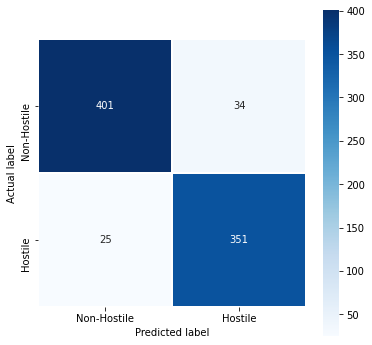

In [ ]:
cm = metrics.confusion_matrix(hostility_y_test, predict_test)
plt.figure(figsize=(6,6))
xticklabels = ['Non-Hostile', 'Hostile']
yticklabels = ['Non-Hostile', 'Hostile']
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues',xticklabels=xticklabels, yticklabels=yticklabels)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## Fine Grained Models

### Defamation

In [ ]:
train = temp_train
test  = temp_test

train = train[train.Hostile!=0]
test = test[test.Hostile!=0]

In [ ]:
print(sum(train['Hostile']))
print(sum(test['Hostile']))

print(sum(train['Defamation']))
print(sum(test['Defamation']))

2678
376
564
77


In [ ]:
train = np.asarray(train)
test = np.asarray(test)

In [ ]:
x_train = train[:,:-6]
y_train = train[:,-5]

x_test = test[:,:-6]
y_test = test[:,-5]

print("x_train: ",x_train.shape)
print("y_train",y_train.shape)
print("x_test",x_test.shape)
print("y_test",y_test.shape)

x_train:  (2678, 12818)
y_train (2678,)
x_test (376, 12818)
y_test (376,)


In [ ]:
from sklearn.linear_model import LogisticRegression
clf = 0
clf = LogisticRegression(penalty='l2',solver='liblinear',max_iter=1000,class_weight='balanced').fit(defamation_x_train, defamation_y_train)

In [ ]:
#Dumping the Random Forest Model
# joblib.dump(clf,r"/gdrive/MyDrive/3rd Sem/MTech CSE 3/Thesis/IIITD Fake News Project/Notebooks/Models/Davidson/Davidson's Models/davidson_defamation_clf.pkl")
clf = joblib.load(r"/gdrive/MyDrive/3rd Sem/MTech CSE 3/Thesis/IIITD Fake News Project/Notebooks/Models/Davidson/Davidson's Models/davidson_defamation_clf.pkl")

In [ ]:
print("\n\nAccuracy report: ")
predict_test = clf.predict(x_test)
print(classification_report(y_test,predict_test))
print(np.unique(predict_test,return_counts = True))
f1 = f1_score(y_true=y_test, y_pred=predict_test, average=None)
print(f1)



Accuracy report: 
              precision    recall  f1-score   support

         0.0       0.81      0.81      0.81       299
         1.0       0.27      0.27      0.27        77

    accuracy                           0.70       376
   macro avg       0.54      0.54      0.54       376
weighted avg       0.70      0.70      0.70       376

(array([0., 1.]), array([297,  79]))
[0.80872483 0.26923077]


Text(0.5, 62.15999999999998, 'Predicted label')

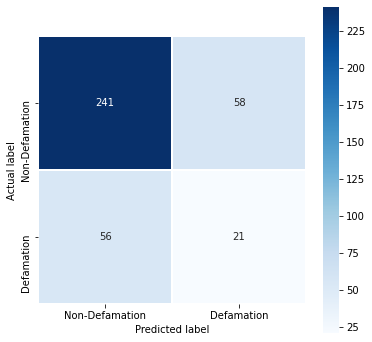

In [ ]:
cm = metrics.confusion_matrix(y_test, predict_test)
plt.figure(figsize=(6,6))
xticklabels = ['Non-Defamation', 'Defamation']
yticklabels = ['Non-Defamation', 'Defamation']
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues',xticklabels=xticklabels, yticklabels=yticklabels)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Fake

In [ ]:
train = temp_train
test  = temp_test

train = train[train.Hostile!=0]
test = test[test.Hostile!=0]

In [ ]:
print(sum(train['Hostile']))
print(sum(test['Hostile']))

print(sum(train['Fake']))
print(sum(test['Fake']))

2678
376
1144
160


In [ ]:
train = np.asarray(train)
test = np.asarray(test)

In [ ]:
x_train = train[:,:-6]
y_train = train[:,-4]

x_test = test[:,:-6]
y_test = test[:,-4]

print("x_train: ",x_train.shape)
print("y_train",y_train.shape)
print("x_test",x_test.shape)
print("y_test",y_test.shape)

x_train:  (2678, 12818)
y_train (2678,)
x_test (376, 12818)
y_test (376,)


In [ ]:
from sklearn.linear_model import LogisticRegression
clf = 0
clf = LogisticRegression(penalty='l2',solver='liblinear',max_iter=1000,class_weight='balanced').fit(defamation_x_train, defamation_y_train)

In [ ]:
#Dumping the Random Forest Model
joblib.dump(clf,r"/gdrive/MyDrive/3rd Sem/MTech CSE 3/Thesis/IIITD Fake News Project/Notebooks/Models/Davidson/Davidson's Models/davidson_fake_clf.pkl")
clf = joblib.load(r"/gdrive/MyDrive/3rd Sem/MTech CSE 3/Thesis/IIITD Fake News Project/Notebooks/Models/Davidson/Davidson's Models/davidson_fake_clf.pkl")

In [ ]:
print("\n\nAccuracy report: ")
predict_test = clf.predict(x_test)
print(classification_report(y_test,predict_test))
print(np.unique(predict_test,return_counts = True))
f1 = f1_score(y_true=y_test, y_pred=predict_test, average=None)
print(f1)



Accuracy report: 
              precision    recall  f1-score   support

         0.0       0.54      0.75      0.63       216
         1.0       0.30      0.15      0.20       160

    accuracy                           0.49       376
   macro avg       0.42      0.45      0.41       376
weighted avg       0.44      0.49      0.45       376

(array([0., 1.]), array([297,  79]))
[0.62768031 0.20083682]


Text(0.5, 62.15999999999998, 'Predicted label')

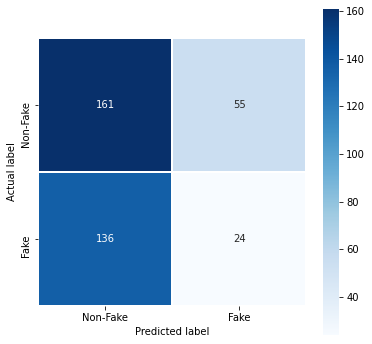

In [ ]:
cm = metrics.confusion_matrix(y_test, predict_test)
plt.figure(figsize=(6,6))
xticklabels = ['Non-Fake', 'Fake']
yticklabels = ['Non-Fake', 'Fake']
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues',xticklabels=xticklabels, yticklabels=yticklabels)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Hate

In [ ]:
train = temp_train
test  = temp_test

train = train[train.Hostile!=0]
test = test[test.Hostile!=0]

In [ ]:
print(sum(train['Hostile']))
print(sum(test['Hostile']))

print(sum(train['Hate']))
print(sum(test['Hate']))

2678
376
792
110


In [ ]:
train = np.asarray(train)
test = np.asarray(test)

In [ ]:
x_train = train[:,:-6]
y_train = train[:,-3]

x_test = test[:,:-6]
y_test = test[:,-3]

print("x_train: ",x_train.shape)
print("y_train",y_train.shape)
print("x_test",x_test.shape)
print("y_test",y_test.shape)

x_train:  (2678, 12818)
y_train (2678,)
x_test (376, 12818)
y_test (376,)


In [ ]:
from sklearn.linear_model import LogisticRegression
clf = 0
clf = LogisticRegression(penalty='l2',solver='liblinear',max_iter=1000,class_weight='balanced').fit(defamation_x_train, defamation_y_train)

In [ ]:
#Dumping the Random Forest Model
# joblib.dump(clf,r"/gdrive/MyDrive/3rd Sem/MTech CSE 3/Thesis/IIITD Fake News Project/Notebooks/Models/Davidson/Davidson's Models/davidson_hate_clf.pkl")
clf = joblib.load(r"/gdrive/MyDrive/3rd Sem/MTech CSE 3/Thesis/IIITD Fake News Project/Notebooks/Models/Davidson/Davidson's Models/davidson_hate_clf.pkl")

In [ ]:
print("\n\nAccuracy report: ")
predict_test = clf.predict(x_test)
print(classification_report(y_test,predict_test))
print(np.unique(predict_test,return_counts = True))
f1 = f1_score(y_true=y_test, y_pred=predict_test, average=None)
print(f1)



Accuracy report: 
              precision    recall  f1-score   support

         0.0       0.73      0.82      0.77       266
         1.0       0.38      0.27      0.32       110

    accuracy                           0.66       376
   macro avg       0.56      0.54      0.54       376
weighted avg       0.63      0.66      0.64       376

(array([0., 1.]), array([297,  79]))
[0.77087034 0.31746032]


Text(0.5, 62.15999999999998, 'Predicted label')

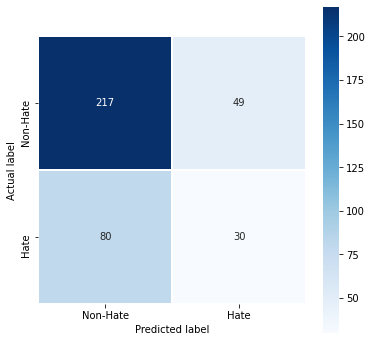

In [ ]:
cm = metrics.confusion_matrix(y_test, predict_test)
plt.figure(figsize=(6,6))
xticklabels = ['Non-Hate', 'Hate']
yticklabels = ['Non-Hate', 'Hate']
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues',xticklabels=xticklabels, yticklabels=yticklabels)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Offensive

In [ ]:
train = temp_train
test  = temp_test

train = train[train.Hostile!=0]
test = test[test.Hostile!=0]

In [ ]:
print(sum(train['Hostile']))
print(sum(test['Hostile']))

print(sum(train['Offensive']))
print(sum(test['Offensive']))

2678
376
742
103


In [ ]:
train = np.asarray(train)
test = np.asarray(test)

In [ ]:
x_train = train[:,:-6]
y_train = train[:,-2]

x_test = test[:,:-6]
y_test = test[:,-2]

print("x_train: ",x_train.shape)
print("y_train",y_train.shape)
print("x_test",x_test.shape)
print("y_test",y_test.shape)

x_train:  (2678, 12818)
y_train (2678,)
x_test (376, 12818)
y_test (376,)


In [ ]:
from sklearn.linear_model import LogisticRegression
clf = 0
clf = LogisticRegression(penalty='l2',solver='liblinear',max_iter=1000,class_weight='balanced').fit(defamation_x_train, defamation_y_train)

In [ ]:
#Dumping the Random Forest Model
# joblib.dump(clf,r"/gdrive/MyDrive/3rd Sem/MTech CSE 3/Thesis/IIITD Fake News Project/Notebooks/Models/Davidson/Davidson's Models/davidson_offensive_clf.pkl")
clf = joblib.load(r"/gdrive/MyDrive/3rd Sem/MTech CSE 3/Thesis/IIITD Fake News Project/Notebooks/Models/Davidson/Davidson's Models/davidson_offensive_clf.pkl")

In [ ]:
print("\n\nAccuracy report: ")
predict_test = clf.predict(x_test)
print(classification_report(y_test,predict_test))
print(np.unique(predict_test,return_counts = True))
f1 = f1_score(y_true=y_test, y_pred=predict_test, average=None)
print(f1)



Accuracy report: 
              precision    recall  f1-score   support

         0.0       0.73      0.79      0.76       273
         1.0       0.28      0.21      0.24       103

    accuracy                           0.63       376
   macro avg       0.50      0.50      0.50       376
weighted avg       0.60      0.63      0.62       376

(array([0., 1.]), array([297,  79]))
[0.75789474 0.24175824]


Text(0.5, 62.15999999999998, 'Predicted label')

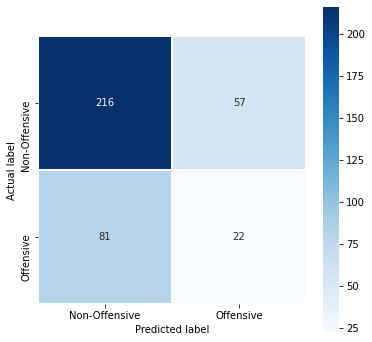

In [ ]:
cm = metrics.confusion_matrix(y_test, predict_test)
plt.figure(figsize=(6,6))
xticklabels = ['Non-Offensive', 'Offensive']
yticklabels = ['Non-Offensive', 'Offensive']
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues',xticklabels=xticklabels, yticklabels=yticklabels)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## Rough Work

In [ ]:
pip install cltk

     |████████████████████████████████| 634kB 7.1MB/s 
     |████████████████████████████████| 163kB 34.8MB/s 
     |████████████████████████████████| 747kB 35.8MB/s 
     |████████████████████████████████| 1.5MB 41.5MB/s 
     |████████████████████████████████| 471kB 39.2MB/s 
     |████████████████████████████████| 71kB 8.0MB/s 
  Created wheel for cltk: filename=cltk-0.1.121-cp36-none-any.whl size=711645 sha256=5ad39a35f24b283440ce469ec53b7480c7fb91bda293f65d41626e0bec291fe2
  Stored in directory: /root/.cache/pip/wheels/03/c9/6b/e60acb6f511ebe008f3e961e894d57598517b25c4cbffbb70f
Successfully built cltk


In [ ]:
pip install pyphen

     |████████████████████████████████| 1.9MB 7.0MB/s 


In [ ]:
import pyphen
dic = pyphen.Pyphen(lang='en')
print (dic.inserted('Mohit'))


Mo-hit


In [ ]:
pip install textstat

     |████████████████████████████████| 102kB 4.6MB/s 


In [ ]:
from textstat.textstat import *


text = 'नमस्ते'
a = textstat.syllable_count(text)
a

1

In [ ]:
from cltk.stem.sanskrit.indian_syllabifier import Syllabifier
input_text = 'नमस्ते'
lang='hindi'
x = Syllabifier(lang)
current = x.orthographic_syllabify(input_text)
# Out[28]: ['न', 'म','स्ते']

FileNotFoundError: ignored

In [ ]:
pip install indic-nlp-library

In [ ]:
from indicnlp.syllable import  syllabifier
w='जगदीशचंद्र'
lang ='hi'
print(' '.join(syllabifier.orthographic_syllabify(w,lang)))
a

AttributeError: ignored

In [ ]:
pip install libindic-utils

  Created wheel for libindic-utils: filename=libindic_utils-1.0.3-cp36-none-any.whl size=9687 sha256=277b75c531c7fb67a3c9ff65a915bdb918607a292ca2d95e1724fea806635cb9
  Stored in directory: /root/.cache/pip/wheels/6e/d7/7d/88295d00bd92de934d21b59b10a4afbffc091fecce779fc4da
Successfully built libindic-utils


In [ ]:
from libindic.utils import get_language
a = get_language(u'অ')
print(a)

bn_IN


In [ ]:
### Reference: https://stackoverflow.com/questions/47000655/syllabification-of-devanagari

import unicodedata

def split_clusters(txt):
    """ Generate grapheme clusters for the Devanagari text."""

    stop = '्'
    cluster = u''
    end = None

    for char in txt:
        category = unicodedata.category(char)
        if (category == 'Lo' and end == stop) or category == 'Mn':
            cluster = cluster + char        
        else:
            if cluster:
                yield cluster
            cluster = char
        end = char

    if cluster:
        yield cluster

In [ ]:
list(split_clusters('नमस्ते'))

['न', 'म', 'स्ते']

In [ ]:
from nltk.tag import tnt
from nltk.corpus import indian

train_data = indian.tagged_sents('hindi.pos')
tnt_pos_tagger = tnt.TnT()
tnt_pos_tagger.train(train_data)

text = train['Processed Tweet Text'][0]
tagged_words = (tnt_pos_tagger.tag(nltk.word_tokenize(text)))
print(tagged_words)

final = []
for pair in tagged_words:
    final.append(pair[1])

print(final)

final = ' '.join(final)
final = [final, final]
# final = list(final)
print(final)


vectorizer = CountVectorizer()
X = vectorizer.fit_transform(final)
print("Feature Names: \n\n",vectorizer.get_feature_names())

In [ ]:
a = train['Processed Tweet Text'][:5]
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(a)
print(vectorizer.get_feature_names())